In [1]:
import logging

import numpy as np
import probtorch
import torch

import bouncing_ball
import bouncing_ball_data
import combinators
import foldable
import importance
import mcmc
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 100 ## sequence length
num_series = 10
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [6]:
num_particles = (100,)

In [7]:
init_bouncing_ball = combinators.PrimitiveCall(bouncing_ball.init_bouncing_ball)

In [8]:
bouncing_ball_step = combinators.PrimitiveCall(bouncing_ball.bouncing_ball_step)

In [9]:
def proposal_step():
    return combinators.PrimitiveCall(bouncing_ball.ProposalStep(), name='bouncing_ball_step')

In [10]:
prior_init_params = {
    'position_0': {
        'loc': torch.zeros(2),
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'loc': {
            'loc': torch.ones(2),
            'scale': torch.ones(2),
        },
        'cov': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [11]:
variational_init_params = {
    'position_0': {
        'loc': torch.zeros(2),
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'loc': {
            'loc': torch.ones(2),
            'scale': torch.ones(2),
        },
        'cov': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [12]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['displacement_%d' % i] = displacements[i-1]
    
    return trajectory, displacements, data

In [13]:
def accumulate_trajectory(inference):
    result = torch.zeros(num_particles[0], len(trajectory), 2)
    result[:, 0] = inference['Reduce(Foldable(SideEffect(bouncing_ball_step, bouncing_ball_step)))/0/init_bouncing_ball/position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce(Foldable(SideEffect(bouncing_ball_step, bouncing_ball_step)))/%d/Foldable(SideEffect(bouncing_ball_step, bouncing_ball_step))(%d,)/bouncing_ball_step/displacement_%d' % (t, t, t+1)].value
    return result

In [14]:
def graph_position_trajectory(positions, T, s):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    plt.savefig('position_trajectory_%d.pdf' % s)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [17]:
def generative_model(data, params):
    params['position_0']['loc'] = data['position_0']
    init_population = combinators.hyper_population(init_bouncing_ball, num_particles,
                                                   hyper=params)
    return mcmc.reduce_resample_move_smc(bouncing_ball_step, num_particles, lambda: range(T),
                                         initializer=init_population)

In [18]:
def proposal_model(data, params):
    params['position_0']['loc'] = data['position_0']
    init_proposal = combinators.hyper_population(init_bouncing_ball, num_particles,
                                                 trainable=params)
    return foldable.Reduce(foldable.Foldable(proposal_step(), initializer=init_proposal), lambda: range(T))

In [19]:
def posterior_model(data, params, step_proposal):
    generative_params = prior_init_params.copy()
    generative_params['position_0']['loc'] = data['position_0']
    
    generative_init = combinators.hyper_population(init_bouncing_ball, num_particles,
                                                   hyper=generative_params)
    params['position_0']['loc'] = data['position_0']
    proposal_init = combinators.hyper_population(init_bouncing_ball, num_particles, hyper=params)
    init_posterior = combinators.score_under_proposal(proposal_init, generative_init)
    
    step_posterior = combinators.score_under_proposal(step_proposal, bouncing_ball_step)
    
    return mcmc.reduce_resample_move_smc(step_posterior, num_particles, lambda: range(T), initializer=init_posterior)

01/30/2019 15:43:05 EUBO=-9.90205002e+01 at epoch 1
01/30/2019 15:43:06 EUBO=7.28253860e+01 at epoch 2
01/30/2019 15:43:07 EUBO=-6.60124695e+02 at epoch 3
01/30/2019 15:43:08 EUBO=1.80884521e+02 at epoch 4
01/30/2019 15:43:09 EUBO=-1.26688330e+03 at epoch 5
01/30/2019 15:43:10 EUBO=1.05747833e+02 at epoch 6
01/30/2019 15:43:11 EUBO=7.96820641e-01 at epoch 7
01/30/2019 15:43:12 EUBO=-1.11680347e+03 at epoch 8
01/30/2019 15:43:13 EUBO=2.93956299e+02 at epoch 9
01/30/2019 15:43:14 EUBO=-5.26698914e+02 at epoch 10
01/30/2019 15:43:15 EUBO=8.41539688e+01 at epoch 11
01/30/2019 15:43:16 EUBO=2.13796219e+02 at epoch 12
01/30/2019 15:43:17 EUBO=1.48079758e+02 at epoch 13
01/30/2019 15:43:18 EUBO=6.20211258e+01 at epoch 14
01/30/2019 15:43:19 EUBO=-2.08714523e+01 at epoch 15
01/30/2019 15:43:20 EUBO=2.66262878e+02 at epoch 16
01/30/2019 15:43:21 EUBO=3.55805111e+00 at epoch 17
01/30/2019 15:43:22 EUBO=1.09967718e+01 at epoch 18
01/30/2019 15:43:23 EUBO=-5.42509094e+02 at epoch 19
01/30/2019 15:

Epoch   293: reducing learning rate of group 0 to 5.0000e-02.


01/30/2019 15:48:18 EUBO=-2.53366333e+03 at epoch 295
01/30/2019 15:48:19 EUBO=5.61475277e+00 at epoch 296
01/30/2019 15:48:20 EUBO=-2.13509094e+02 at epoch 297
01/30/2019 15:48:21 EUBO=-3.91680969e+02 at epoch 298
01/30/2019 15:48:22 EUBO=1.22413116e+02 at epoch 299
01/30/2019 15:48:23 EUBO=9.81732712e+01 at epoch 300
01/30/2019 15:48:24 EUBO=7.87854767e+01 at epoch 301
01/30/2019 15:48:25 EUBO=-2.59168926e+04 at epoch 302
01/30/2019 15:48:26 EUBO=3.51033630e+02 at epoch 303
01/30/2019 15:48:27 EUBO=-1.90899414e+02 at epoch 304
01/30/2019 15:48:28 EUBO=-2.23302222e+03 at epoch 305
01/30/2019 15:48:29 EUBO=-1.56443909e+02 at epoch 306
01/30/2019 15:48:30 EUBO=5.90837479e+01 at epoch 307
01/30/2019 15:48:31 EUBO=1.79601624e+02 at epoch 308
01/30/2019 15:48:33 EUBO=3.17916641e+01 at epoch 309
01/30/2019 15:48:34 EUBO=1.18397652e+02 at epoch 310
01/30/2019 15:48:35 EUBO=1.24454842e+02 at epoch 311
01/30/2019 15:48:36 EUBO=-1.93320801e+02 at epoch 312
01/30/2019 15:48:37 EUBO=2.67700256e+0

Epoch   494: reducing learning rate of group 0 to 2.5000e-02.


01/30/2019 15:51:50 EUBO=3.07093277e+01 at epoch 496
01/30/2019 15:51:51 EUBO=6.93126297e+01 at epoch 497
01/30/2019 15:51:52 EUBO=-3.57025940e+02 at epoch 498
01/30/2019 15:51:53 EUBO=-8.62810242e+02 at epoch 499
01/30/2019 15:51:54 EUBO=1.43116760e+02 at epoch 500


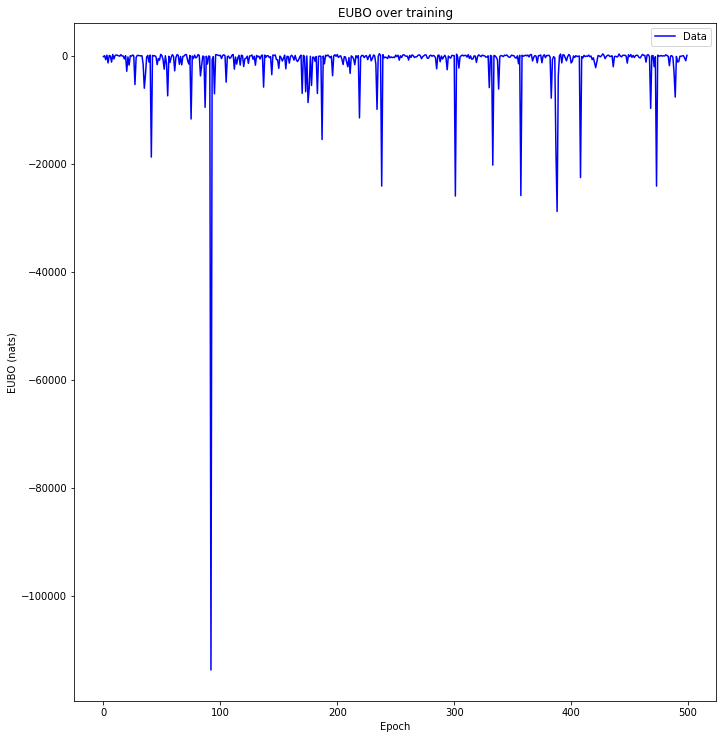

01/30/2019 15:51:57 EUBO=-6.83854492e+02 at epoch 1
01/30/2019 15:51:58 EUBO=3.40789490e+02 at epoch 2
01/30/2019 15:51:59 EUBO=1.42313965e+02 at epoch 3
01/30/2019 15:52:00 EUBO=1.27183632e+02 at epoch 4
01/30/2019 15:52:01 EUBO=-5.02360779e+02 at epoch 5
01/30/2019 15:52:03 EUBO=-5.13580261e+02 at epoch 6
01/30/2019 15:52:04 EUBO=1.81305908e+02 at epoch 7
01/30/2019 15:52:05 EUBO=1.10587532e+02 at epoch 8
01/30/2019 15:52:06 EUBO=1.30867676e+02 at epoch 9
01/30/2019 15:52:07 EUBO=7.29206009e+01 at epoch 10
01/30/2019 15:52:08 EUBO=2.75290588e+02 at epoch 11
01/30/2019 15:52:09 EUBO=1.08007698e+02 at epoch 12
01/30/2019 15:52:10 EUBO=1.56647980e+02 at epoch 13
01/30/2019 15:52:11 EUBO=2.88265808e+02 at epoch 14
01/30/2019 15:52:12 EUBO=1.69920883e+02 at epoch 15
01/30/2019 15:52:13 EUBO=-4.84252979e+03 at epoch 16
01/30/2019 15:52:14 EUBO=6.94495010e+01 at epoch 17
01/30/2019 15:52:15 EUBO=1.80961548e+02 at epoch 18
01/30/2019 15:52:16 EUBO=-1.33110962e+02 at epoch 19
01/30/2019 15:52

Epoch   258: reducing learning rate of group 0 to 5.0000e-02.


01/30/2019 15:56:35 EUBO=2.34325867e+02 at epoch 260
01/30/2019 15:56:36 EUBO=-1.17070496e+03 at epoch 261
01/30/2019 15:56:37 EUBO=6.62225723e+01 at epoch 262
01/30/2019 15:56:38 EUBO=1.91993027e+02 at epoch 263
01/30/2019 15:56:39 EUBO=-1.06764160e+04 at epoch 264
01/30/2019 15:56:40 EUBO=-2.21822205e+02 at epoch 265
01/30/2019 15:56:41 EUBO=1.14657600e+02 at epoch 266
01/30/2019 15:56:42 EUBO=8.46742325e+01 at epoch 267
01/30/2019 15:56:43 EUBO=1.18108620e+02 at epoch 268
01/30/2019 15:56:44 EUBO=3.90353470e+01 at epoch 269
01/30/2019 15:56:45 EUBO=1.28815735e+02 at epoch 270
01/30/2019 15:56:46 EUBO=2.68849258e+01 at epoch 271
01/30/2019 15:56:48 EUBO=1.52447882e+01 at epoch 272
01/30/2019 15:56:49 EUBO=1.60108459e+02 at epoch 273
01/30/2019 15:56:50 EUBO=-1.86144333e+01 at epoch 274
01/30/2019 15:56:51 EUBO=1.95846283e+02 at epoch 275
01/30/2019 15:56:52 EUBO=1.04261360e+02 at epoch 276
01/30/2019 15:56:53 EUBO=1.54528900e+02 at epoch 277
01/30/2019 15:56:55 EUBO=-2.78152390e+01 a

Epoch   459: reducing learning rate of group 0 to 2.5000e-02.


01/30/2019 16:00:07 EUBO=8.95587540e+01 at epoch 461
01/30/2019 16:00:08 EUBO=-3.51070496e+02 at epoch 462
01/30/2019 16:00:09 EUBO=4.34206619e+01 at epoch 463
01/30/2019 16:00:10 EUBO=-1.75313416e+02 at epoch 464
01/30/2019 16:00:11 EUBO=-3.13530827e+00 at epoch 465
01/30/2019 16:00:13 EUBO=4.90752029e+01 at epoch 466
01/30/2019 16:00:14 EUBO=-2.42470923e+03 at epoch 467
01/30/2019 16:00:15 EUBO=-2.76842163e+02 at epoch 468
01/30/2019 16:00:16 EUBO=-4.30434180e+03 at epoch 469
01/30/2019 16:00:17 EUBO=6.74575882e+01 at epoch 470
01/30/2019 16:00:18 EUBO=6.03327560e+01 at epoch 471
01/30/2019 16:00:19 EUBO=-9.07650089e+00 at epoch 472
01/30/2019 16:00:20 EUBO=-5.75294067e+02 at epoch 473
01/30/2019 16:00:21 EUBO=-9.32166061e+01 at epoch 474
01/30/2019 16:00:22 EUBO=-6.96145203e+02 at epoch 475
01/30/2019 16:00:23 EUBO=-1.97300339e+01 at epoch 476
01/30/2019 16:00:24 EUBO=2.74274750e+02 at epoch 477
01/30/2019 16:00:25 EUBO=-2.33039780e+01 at epoch 478
01/30/2019 16:00:26 EUBO=3.8256814

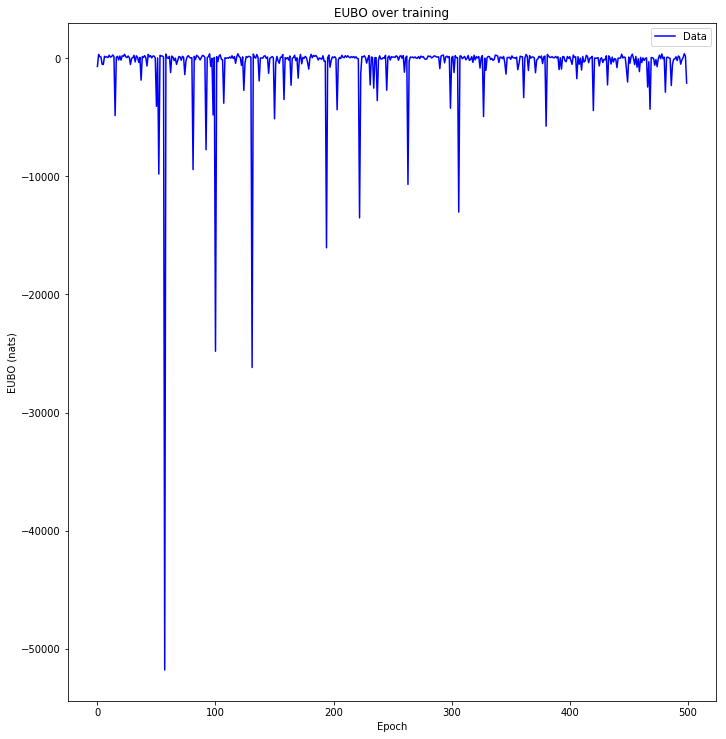

01/30/2019 16:00:52 EUBO=1.56222229e+02 at epoch 1
01/30/2019 16:00:53 EUBO=-3.05841445e+04 at epoch 2
01/30/2019 16:00:54 EUBO=-4.16624219e+03 at epoch 3
01/30/2019 16:00:56 EUBO=1.49311554e+02 at epoch 4
01/30/2019 16:00:57 EUBO=-8.46526562e+03 at epoch 5
01/30/2019 16:00:58 EUBO=1.13735237e+02 at epoch 6
01/30/2019 16:00:59 EUBO=-1.06482109e+02 at epoch 7
01/30/2019 16:01:00 EUBO=4.47273026e+01 at epoch 8
01/30/2019 16:01:01 EUBO=1.21564789e+02 at epoch 9
01/30/2019 16:01:03 EUBO=1.41692871e+02 at epoch 10
01/30/2019 16:01:04 EUBO=2.78015213e+01 at epoch 11
01/30/2019 16:01:05 EUBO=1.71909851e+02 at epoch 12
01/30/2019 16:01:06 EUBO=7.89367142e+01 at epoch 13
01/30/2019 16:01:07 EUBO=2.76200012e+02 at epoch 14
01/30/2019 16:01:08 EUBO=1.49671616e+02 at epoch 15
01/30/2019 16:01:09 EUBO=5.54833031e+01 at epoch 16
01/30/2019 16:01:11 EUBO=-1.21390801e+04 at epoch 17
01/30/2019 16:01:12 EUBO=-9.51016769e+01 at epoch 18
01/30/2019 16:01:13 EUBO=2.99598694e+02 at epoch 19
01/30/2019 16:0

Epoch   202: reducing learning rate of group 0 to 5.0000e-02.


01/30/2019 16:04:29 EUBO=-9.34868717e+00 at epoch 204
01/30/2019 16:04:30 EUBO=6.88751907e+01 at epoch 205
01/30/2019 16:04:31 EUBO=2.67493622e+02 at epoch 206
01/30/2019 16:04:32 EUBO=-1.37901465e+03 at epoch 207
01/30/2019 16:04:33 EUBO=1.83632843e+02 at epoch 208
01/30/2019 16:04:34 EUBO=-3.73876572e+01 at epoch 209
01/30/2019 16:04:35 EUBO=1.63486938e+02 at epoch 210
01/30/2019 16:04:37 EUBO=1.13269295e+02 at epoch 211
01/30/2019 16:04:38 EUBO=3.81597260e+02 at epoch 212
01/30/2019 16:04:39 EUBO=-6.40386780e+02 at epoch 213
01/30/2019 16:04:40 EUBO=9.45492935e+01 at epoch 214
01/30/2019 16:04:41 EUBO=-3.50489087e+03 at epoch 215
01/30/2019 16:04:42 EUBO=2.70325287e+02 at epoch 216
01/30/2019 16:04:43 EUBO=-5.21077881e+02 at epoch 217
01/30/2019 16:04:44 EUBO=3.05953094e+02 at epoch 218
01/30/2019 16:04:45 EUBO=-6.34263229e+01 at epoch 219
01/30/2019 16:04:46 EUBO=-1.76751137e-01 at epoch 220
01/30/2019 16:04:47 EUBO=3.19631836e+02 at epoch 221
01/30/2019 16:04:48 EUBO=5.27869949e+0

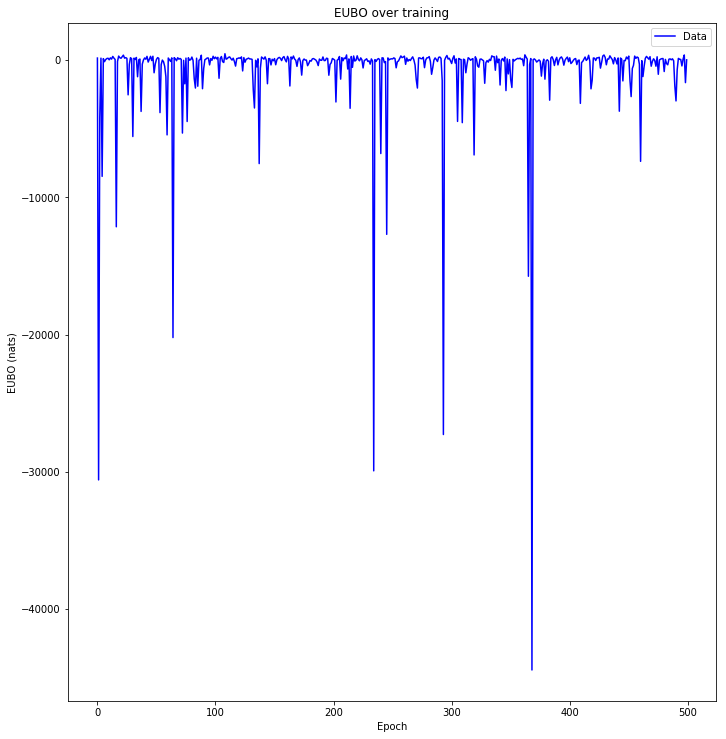

01/30/2019 16:09:44 EUBO=-1.06516089e+03 at epoch 1
01/30/2019 16:09:46 EUBO=2.62945068e+02 at epoch 2
01/30/2019 16:09:47 EUBO=1.78507996e+02 at epoch 3
01/30/2019 16:09:48 EUBO=1.17772194e+02 at epoch 4
01/30/2019 16:09:49 EUBO=-3.99982719e+01 at epoch 5
01/30/2019 16:09:50 EUBO=-1.50993970e+03 at epoch 6
01/30/2019 16:09:51 EUBO=-1.41203857e+02 at epoch 7
01/30/2019 16:09:52 EUBO=-2.71223804e+03 at epoch 8
01/30/2019 16:09:53 EUBO=-3.93740332e+03 at epoch 9
01/30/2019 16:09:54 EUBO=-3.46553979e+03 at epoch 10
01/30/2019 16:09:55 EUBO=-5.53545361e+03 at epoch 11
01/30/2019 16:09:56 EUBO=-2.11313647e+03 at epoch 12
01/30/2019 16:09:57 EUBO=-1.46544238e+03 at epoch 13
01/30/2019 16:09:58 EUBO=-7.15449200e+06 at epoch 14
01/30/2019 16:09:59 EUBO=-6.96640320e+02 at epoch 15
01/30/2019 16:10:00 EUBO=1.67469910e+02 at epoch 16
01/30/2019 16:10:02 EUBO=9.91927567e+01 at epoch 17
01/30/2019 16:10:03 EUBO=9.38953018e+01 at epoch 18
01/30/2019 16:10:04 EUBO=-2.78583936e+03 at epoch 19
01/30/20

Epoch   214: reducing learning rate of group 0 to 5.0000e-02.


01/30/2019 16:13:24 EUBO=-3.57207870e+01 at epoch 216
01/30/2019 16:13:25 EUBO=-4.14129150e+02 at epoch 217
01/30/2019 16:13:26 EUBO=-4.44979889e+02 at epoch 218
01/30/2019 16:13:27 EUBO=-2.07866440e+01 at epoch 219
01/30/2019 16:13:28 EUBO=1.16491310e+02 at epoch 220
01/30/2019 16:13:30 EUBO=-8.84781113e+01 at epoch 221
01/30/2019 16:13:31 EUBO=-1.61731262e+02 at epoch 222
01/30/2019 16:13:32 EUBO=8.45546036e+01 at epoch 223
01/30/2019 16:13:33 EUBO=-1.33682119e+04 at epoch 224
01/30/2019 16:13:34 EUBO=1.14788765e+02 at epoch 225
01/30/2019 16:13:35 EUBO=2.83022003e+02 at epoch 226
01/30/2019 16:13:36 EUBO=-8.62363098e+02 at epoch 227
01/30/2019 16:13:37 EUBO=-9.17683640e+01 at epoch 228
01/30/2019 16:13:38 EUBO=-5.39891663e+02 at epoch 229
01/30/2019 16:13:39 EUBO=1.67236618e+02 at epoch 230
01/30/2019 16:13:40 EUBO=1.97497223e+02 at epoch 231
01/30/2019 16:13:41 EUBO=1.13312386e+02 at epoch 232
01/30/2019 16:13:42 EUBO=-2.52012695e+02 at epoch 233
01/30/2019 16:13:43 EUBO=6.13394852

Epoch   415: reducing learning rate of group 0 to 2.5000e-02.


01/30/2019 16:16:46 EUBO=5.95696487e+01 at epoch 417
01/30/2019 16:16:47 EUBO=-3.60464941e+03 at epoch 418
01/30/2019 16:16:48 EUBO=1.52393433e+02 at epoch 419
01/30/2019 16:16:49 EUBO=-7.82333679e+02 at epoch 420
01/30/2019 16:16:50 EUBO=-3.76600952e+02 at epoch 421
01/30/2019 16:16:51 EUBO=9.37637100e+01 at epoch 422
01/30/2019 16:16:52 EUBO=-1.86967773e+02 at epoch 423
01/30/2019 16:16:53 EUBO=-6.19083786e+01 at epoch 424
01/30/2019 16:16:54 EUBO=-2.41276611e+02 at epoch 425
01/30/2019 16:16:55 EUBO=-9.67657471e+02 at epoch 426
01/30/2019 16:16:56 EUBO=-7.81555237e+02 at epoch 427
01/30/2019 16:16:57 EUBO=-7.95086121e+02 at epoch 428
01/30/2019 16:16:58 EUBO=8.32758236e+00 at epoch 429
01/30/2019 16:16:59 EUBO=-4.52466011e+00 at epoch 430
01/30/2019 16:17:00 EUBO=-4.27802344e+03 at epoch 431
01/30/2019 16:17:01 EUBO=2.16523499e+02 at epoch 432
01/30/2019 16:17:02 EUBO=4.32122269e+01 at epoch 433
01/30/2019 16:17:02 EUBO=-2.46484909e+01 at epoch 434
01/30/2019 16:17:03 EUBO=-4.354362

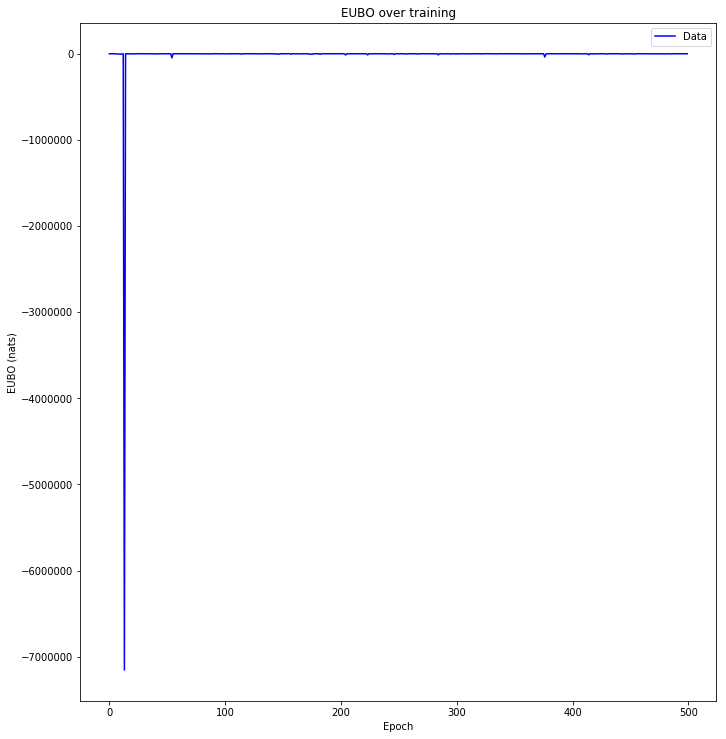

01/30/2019 16:18:10 EUBO=-8.26936569e+01 at epoch 1
01/30/2019 16:18:11 EUBO=1.90147491e+02 at epoch 2
01/30/2019 16:18:12 EUBO=-4.76138367e+02 at epoch 3
01/30/2019 16:18:13 EUBO=-2.50184355e+04 at epoch 4
01/30/2019 16:18:15 EUBO=-3.62397949e+02 at epoch 5
01/30/2019 16:18:16 EUBO=-9.11858463e+00 at epoch 6
01/30/2019 16:18:17 EUBO=-1.89393738e+02 at epoch 7
01/30/2019 16:18:18 EUBO=-1.06684619e+03 at epoch 8
01/30/2019 16:18:19 EUBO=2.15717926e+02 at epoch 9
01/30/2019 16:18:20 EUBO=2.59148438e+02 at epoch 10
01/30/2019 16:18:21 EUBO=-1.59201126e+02 at epoch 11
01/30/2019 16:18:22 EUBO=-1.07482941e+02 at epoch 12
01/30/2019 16:18:23 EUBO=-8.10900391e+02 at epoch 13
01/30/2019 16:18:24 EUBO=-7.11601624e+02 at epoch 14
01/30/2019 16:18:25 EUBO=-1.99501099e+02 at epoch 15
01/30/2019 16:18:26 EUBO=2.40123199e+02 at epoch 16
01/30/2019 16:18:27 EUBO=-1.09760779e+03 at epoch 17
01/30/2019 16:18:28 EUBO=-2.10923364e+03 at epoch 18
01/30/2019 16:18:29 EUBO=-5.93813171e+02 at epoch 19
01/30/

Epoch   296: reducing learning rate of group 0 to 5.0000e-02.


01/30/2019 16:23:09 EUBO=-8.42308411e+02 at epoch 298
01/30/2019 16:23:10 EUBO=1.87133118e+02 at epoch 299
01/30/2019 16:23:11 EUBO=-5.81156540e+01 at epoch 300
01/30/2019 16:23:11 EUBO=1.31114197e+02 at epoch 301
01/30/2019 16:23:12 EUBO=-1.51099834e+04 at epoch 302
01/30/2019 16:23:13 EUBO=1.61449432e+02 at epoch 303
01/30/2019 16:23:15 EUBO=-4.24175949e+01 at epoch 304
01/30/2019 16:23:16 EUBO=-1.70740991e+03 at epoch 305
01/30/2019 16:23:17 EUBO=-3.03306580e+02 at epoch 306
01/30/2019 16:23:18 EUBO=-4.41500187e+00 at epoch 307
01/30/2019 16:23:19 EUBO=-1.51481995e+02 at epoch 308
01/30/2019 16:23:20 EUBO=2.16123047e+02 at epoch 309
01/30/2019 16:23:21 EUBO=-1.21589668e+02 at epoch 310
01/30/2019 16:23:22 EUBO=1.02704525e+00 at epoch 311
01/30/2019 16:23:23 EUBO=2.87567215e+01 at epoch 312
01/30/2019 16:23:24 EUBO=2.07623291e+02 at epoch 313
01/30/2019 16:23:25 EUBO=1.92202744e+02 at epoch 314
01/30/2019 16:23:26 EUBO=-3.66732101e+01 at epoch 315
01/30/2019 16:23:27 EUBO=-1.80096664

Epoch   497: reducing learning rate of group 0 to 2.5000e-02.


01/30/2019 16:26:32 EUBO=3.00698486e+02 at epoch 499
01/30/2019 16:26:33 EUBO=-3.15359009e+02 at epoch 500


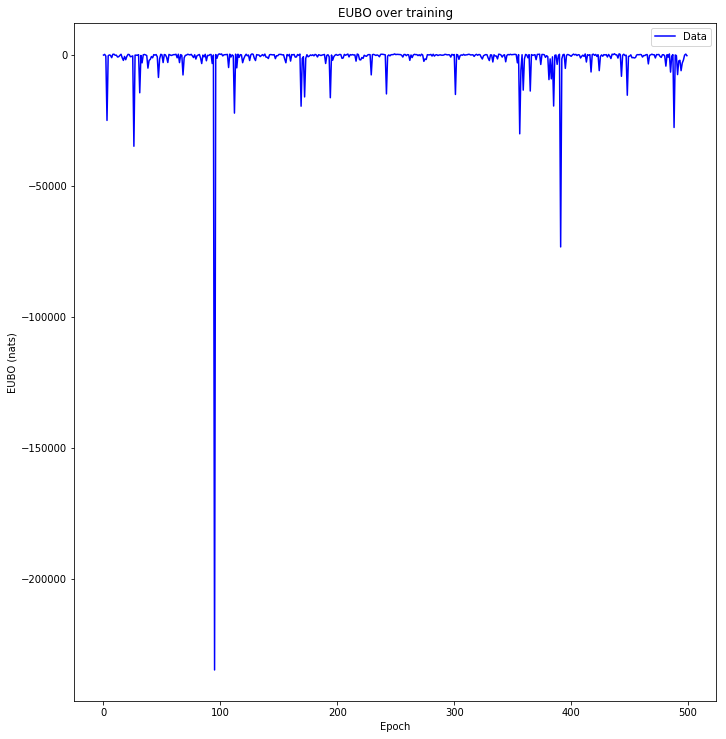

01/30/2019 16:26:36 EUBO=-5.27961060e+02 at epoch 1
01/30/2019 16:26:37 EUBO=-6.79202576e+02 at epoch 2
01/30/2019 16:26:38 EUBO=-1.15742668e+02 at epoch 3
01/30/2019 16:26:39 EUBO=-5.22265259e+02 at epoch 4
01/30/2019 16:26:40 EUBO=-1.15668145e+04 at epoch 5
01/30/2019 16:26:41 EUBO=-1.56546631e+03 at epoch 6
01/30/2019 16:26:42 EUBO=-8.88077316e+01 at epoch 7
01/30/2019 16:26:43 EUBO=-1.69981616e+03 at epoch 8
01/30/2019 16:26:44 EUBO=7.82307816e+01 at epoch 9
01/30/2019 16:26:45 EUBO=1.41008331e+02 at epoch 10
01/30/2019 16:26:46 EUBO=2.15549942e+02 at epoch 11
01/30/2019 16:26:47 EUBO=-2.23804169e+02 at epoch 12
01/30/2019 16:26:48 EUBO=-7.91084290e+02 at epoch 13
01/30/2019 16:26:50 EUBO=-1.17830488e+04 at epoch 14
01/30/2019 16:26:51 EUBO=-6.10793518e+02 at epoch 15
01/30/2019 16:26:52 EUBO=1.64670486e+01 at epoch 16
01/30/2019 16:26:53 EUBO=-7.60999069e+01 at epoch 17
01/30/2019 16:26:54 EUBO=-1.07759697e+02 at epoch 18
01/30/2019 16:26:55 EUBO=8.84854965e+01 at epoch 19
01/30/2

Epoch   306: reducing learning rate of group 0 to 5.0000e-02.


01/30/2019 16:32:23 EUBO=-1.22222834e+01 at epoch 308
01/30/2019 16:32:24 EUBO=-2.94660416e+01 at epoch 309
01/30/2019 16:32:25 EUBO=1.34244171e+02 at epoch 310
01/30/2019 16:32:26 EUBO=-1.82992065e+02 at epoch 311
01/30/2019 16:32:27 EUBO=1.33211365e+02 at epoch 312
01/30/2019 16:32:29 EUBO=9.70549698e+01 at epoch 313
01/30/2019 16:32:30 EUBO=2.35139847e+01 at epoch 314
01/30/2019 16:32:31 EUBO=1.23968878e+01 at epoch 315
01/30/2019 16:32:32 EUBO=1.05429970e+02 at epoch 316
01/30/2019 16:32:33 EUBO=1.19413307e+02 at epoch 317
01/30/2019 16:32:34 EUBO=1.24605049e+02 at epoch 318
01/30/2019 16:32:35 EUBO=-1.23284340e-01 at epoch 319
01/30/2019 16:32:37 EUBO=6.40137100e+01 at epoch 320
01/30/2019 16:32:38 EUBO=1.55121429e+02 at epoch 321
01/30/2019 16:32:39 EUBO=-2.66475098e+02 at epoch 322
01/30/2019 16:32:40 EUBO=1.52011169e+02 at epoch 323
01/30/2019 16:32:41 EUBO=-3.59040088e+03 at epoch 324
01/30/2019 16:32:42 EUBO=-6.14062158e+03 at epoch 325
01/30/2019 16:32:43 EUBO=-9.87760071e+0

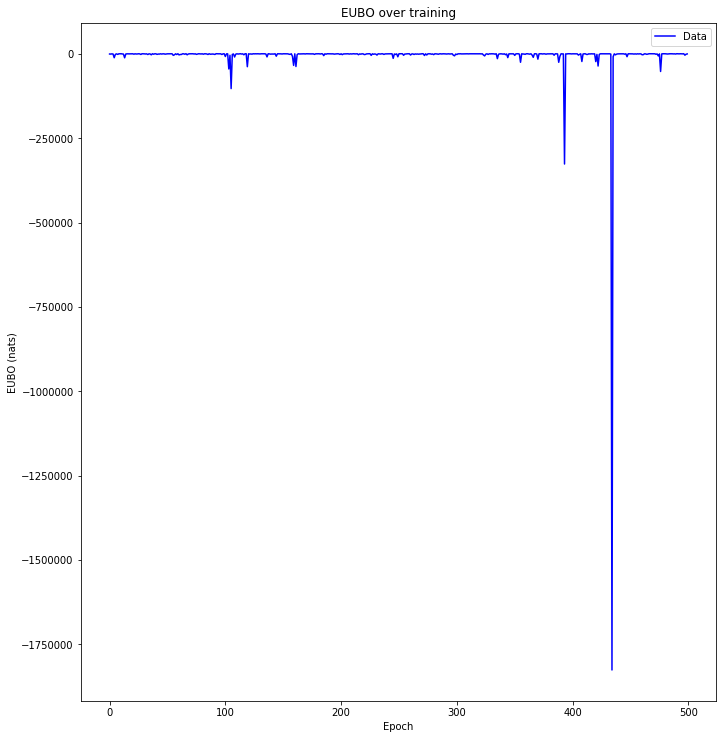

01/30/2019 16:36:02 EUBO=1.07644417e+02 at epoch 1
01/30/2019 16:36:03 EUBO=-1.14807568e+03 at epoch 2
01/30/2019 16:36:05 EUBO=1.17269981e+02 at epoch 3
01/30/2019 16:36:06 EUBO=1.22460487e+02 at epoch 4
01/30/2019 16:36:07 EUBO=-2.52294495e+02 at epoch 5
01/30/2019 16:36:08 EUBO=-4.71203064e+02 at epoch 6
01/30/2019 16:36:09 EUBO=7.52749405e+01 at epoch 7
01/30/2019 16:36:10 EUBO=-9.99938889e+01 at epoch 8
01/30/2019 16:36:11 EUBO=-4.45468628e+02 at epoch 9
01/30/2019 16:36:12 EUBO=2.88729645e+02 at epoch 10
01/30/2019 16:36:13 EUBO=2.25710999e+02 at epoch 11
01/30/2019 16:36:14 EUBO=1.59053223e+02 at epoch 12
01/30/2019 16:36:16 EUBO=1.95894470e+02 at epoch 13
01/30/2019 16:36:17 EUBO=1.92029083e+02 at epoch 14
01/30/2019 16:36:18 EUBO=5.67544632e+01 at epoch 15
01/30/2019 16:36:19 EUBO=2.11189148e+02 at epoch 16
01/30/2019 16:36:20 EUBO=3.17775635e+02 at epoch 17
01/30/2019 16:36:21 EUBO=6.01947060e+01 at epoch 18
01/30/2019 16:36:22 EUBO=2.20763397e+02 at epoch 19
01/30/2019 16:36

Epoch   489: reducing learning rate of group 0 to 5.0000e-02.


01/30/2019 16:44:56 EUBO=-1.13942456e+03 at epoch 491
01/30/2019 16:44:57 EUBO=7.81398697e+01 at epoch 492
01/30/2019 16:44:58 EUBO=2.13783875e+02 at epoch 493
01/30/2019 16:44:59 EUBO=1.67965881e+02 at epoch 494
01/30/2019 16:45:00 EUBO=1.30772812e+02 at epoch 495
01/30/2019 16:45:01 EUBO=-1.03267395e+03 at epoch 496
01/30/2019 16:45:02 EUBO=2.45168274e+02 at epoch 497
01/30/2019 16:45:04 EUBO=-1.88573059e+02 at epoch 498
01/30/2019 16:45:05 EUBO=-3.45675583e+01 at epoch 499
01/30/2019 16:45:06 EUBO=-4.47485840e+02 at epoch 500


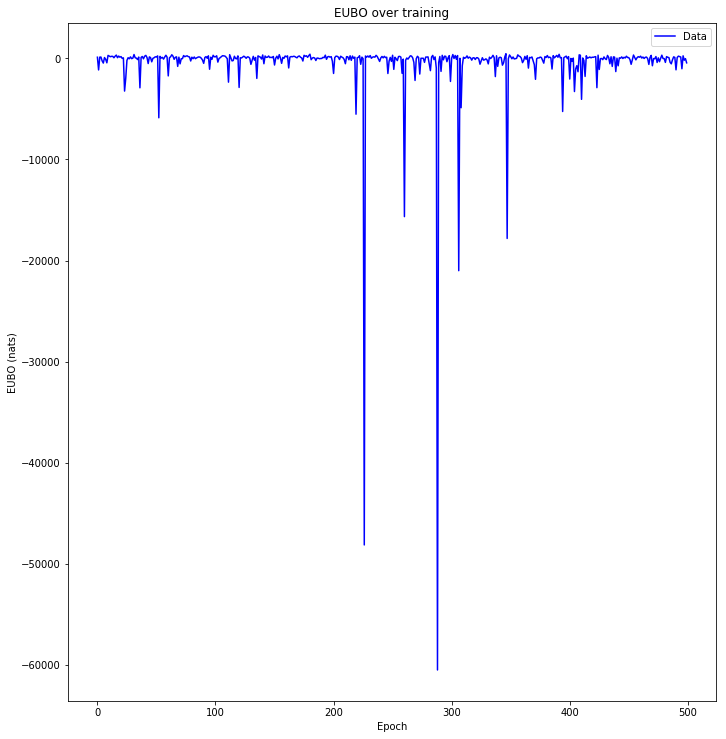

01/30/2019 16:45:09 EUBO=1.26161499e+02 at epoch 1
01/30/2019 16:45:10 EUBO=1.82720215e+02 at epoch 2
01/30/2019 16:45:11 EUBO=-3.67229538e+01 at epoch 3
01/30/2019 16:45:12 EUBO=1.12281929e+02 at epoch 4
01/30/2019 16:45:13 EUBO=-8.95269108e+00 at epoch 5
01/30/2019 16:45:14 EUBO=-8.38914673e+02 at epoch 6
01/30/2019 16:45:15 EUBO=1.30945496e+02 at epoch 7
01/30/2019 16:45:17 EUBO=-1.03942246e+04 at epoch 8
01/30/2019 16:45:18 EUBO=2.94913788e+02 at epoch 9
01/30/2019 16:45:19 EUBO=-1.61296655e+03 at epoch 10
01/30/2019 16:45:20 EUBO=-3.92621191e+03 at epoch 11
01/30/2019 16:45:21 EUBO=-2.02239197e+02 at epoch 12
01/30/2019 16:45:22 EUBO=-2.41052307e+02 at epoch 13
01/30/2019 16:45:23 EUBO=-6.12513580e+01 at epoch 14
01/30/2019 16:45:24 EUBO=1.11402412e+02 at epoch 15
01/30/2019 16:45:25 EUBO=-2.32834448e+03 at epoch 16
01/30/2019 16:45:26 EUBO=2.84962067e+02 at epoch 17
01/30/2019 16:45:27 EUBO=-2.40196558e+03 at epoch 18
01/30/2019 16:45:28 EUBO=1.07305977e+02 at epoch 19
01/30/2019

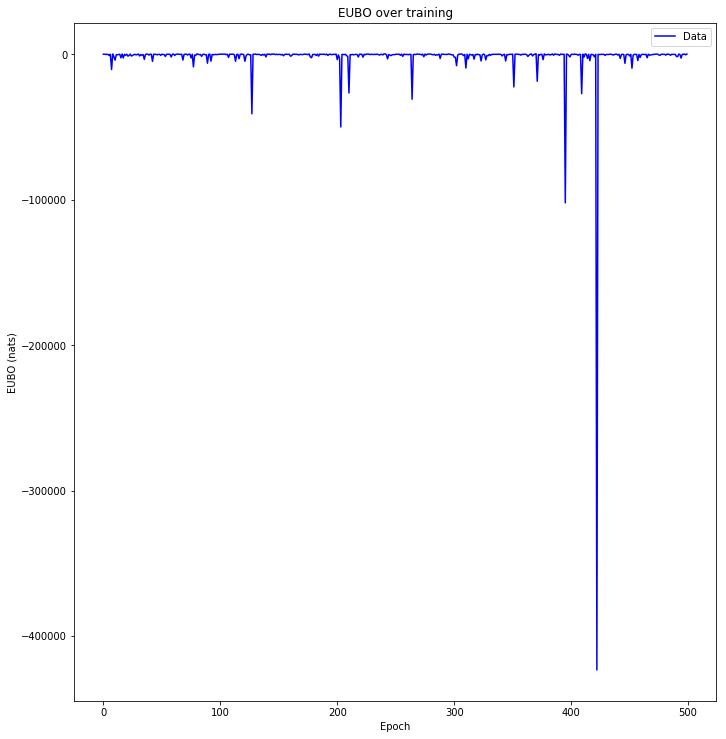

01/30/2019 16:53:52 EUBO=2.82855652e+02 at epoch 1
01/30/2019 16:53:53 EUBO=6.32106705e+01 at epoch 2
01/30/2019 16:53:55 EUBO=-1.29264099e+02 at epoch 3
01/30/2019 16:53:56 EUBO=4.82478714e+01 at epoch 4
01/30/2019 16:53:57 EUBO=1.28635986e+02 at epoch 5
01/30/2019 16:53:58 EUBO=3.12472473e+02 at epoch 6
01/30/2019 16:53:59 EUBO=1.21969551e+02 at epoch 7
01/30/2019 16:54:00 EUBO=2.34211670e+02 at epoch 8
01/30/2019 16:54:01 EUBO=2.19185791e+02 at epoch 9
01/30/2019 16:54:02 EUBO=1.04856331e+02 at epoch 10
01/30/2019 16:54:03 EUBO=-5.74851562e+02 at epoch 11
01/30/2019 16:54:04 EUBO=6.09254227e+01 at epoch 12
01/30/2019 16:54:05 EUBO=1.62409271e+02 at epoch 13
01/30/2019 16:54:06 EUBO=2.21347260e+02 at epoch 14
01/30/2019 16:54:07 EUBO=1.58217468e+02 at epoch 15
01/30/2019 16:54:08 EUBO=3.82412796e+01 at epoch 16
01/30/2019 16:54:09 EUBO=1.81348038e+01 at epoch 17
01/30/2019 16:54:10 EUBO=3.77835938e+02 at epoch 18
01/30/2019 16:54:11 EUBO=4.46044998e+01 at epoch 19
01/30/2019 16:54:12

Epoch   412: reducing learning rate of group 0 to 5.0000e-02.


01/30/2019 17:01:15 EUBO=6.63414993e+01 at epoch 414
01/30/2019 17:01:16 EUBO=-3.04749069e+01 at epoch 415
01/30/2019 17:01:17 EUBO=-1.11008934e+02 at epoch 416
01/30/2019 17:01:18 EUBO=1.39638550e+02 at epoch 417
01/30/2019 17:01:19 EUBO=-4.29326318e+03 at epoch 418
01/30/2019 17:01:20 EUBO=1.07968117e+02 at epoch 419
01/30/2019 17:01:21 EUBO=1.21680733e+02 at epoch 420
01/30/2019 17:01:22 EUBO=-1.16867114e+03 at epoch 421
01/30/2019 17:01:23 EUBO=-3.38742981e+02 at epoch 422
01/30/2019 17:01:24 EUBO=1.59291687e+02 at epoch 423
01/30/2019 17:01:25 EUBO=6.12106991e+00 at epoch 424
01/30/2019 17:01:26 EUBO=4.91402359e+01 at epoch 425
01/30/2019 17:01:27 EUBO=1.01561592e+02 at epoch 426
01/30/2019 17:01:28 EUBO=1.22940186e+02 at epoch 427
01/30/2019 17:01:29 EUBO=1.23493340e+02 at epoch 428
01/30/2019 17:01:30 EUBO=4.45030289e+01 at epoch 429
01/30/2019 17:01:31 EUBO=1.12104866e+02 at epoch 430
01/30/2019 17:01:32 EUBO=-2.61824646e+02 at epoch 431
01/30/2019 17:01:33 EUBO=8.10034256e+01 

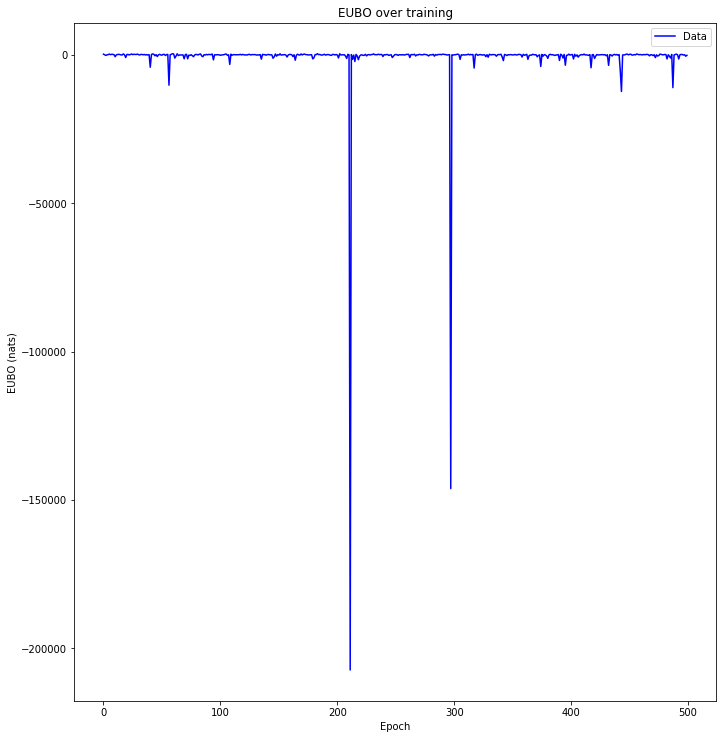

01/30/2019 17:02:44 EUBO=-2.89672455e+02 at epoch 1
01/30/2019 17:02:45 EUBO=1.50204102e+02 at epoch 2
01/30/2019 17:02:46 EUBO=1.14955206e+01 at epoch 3
01/30/2019 17:02:47 EUBO=1.02599556e+02 at epoch 4
01/30/2019 17:02:48 EUBO=2.41758102e+02 at epoch 5
01/30/2019 17:02:49 EUBO=6.09634171e+01 at epoch 6
01/30/2019 17:02:50 EUBO=-1.30460083e+02 at epoch 7
01/30/2019 17:02:51 EUBO=-3.01901428e+02 at epoch 8
01/30/2019 17:02:52 EUBO=1.07286873e+02 at epoch 9
01/30/2019 17:02:53 EUBO=2.93028717e+02 at epoch 10
01/30/2019 17:02:54 EUBO=-2.79832687e+01 at epoch 11
01/30/2019 17:02:55 EUBO=3.98160492e+02 at epoch 12
01/30/2019 17:02:56 EUBO=-3.70556445e+03 at epoch 13
01/30/2019 17:02:57 EUBO=-4.01686289e+04 at epoch 14
01/30/2019 17:02:59 EUBO=2.04928192e+02 at epoch 15
01/30/2019 17:03:00 EUBO=2.24634521e+02 at epoch 16
01/30/2019 17:03:00 EUBO=-7.12708862e+02 at epoch 17
01/30/2019 17:03:01 EUBO=6.47113705e+00 at epoch 18
01/30/2019 17:03:02 EUBO=-5.42153854e+01 at epoch 19
01/30/2019 17

Epoch   214: reducing learning rate of group 0 to 5.0000e-02.


01/30/2019 17:06:26 EUBO=1.15953667e+02 at epoch 216
01/30/2019 17:06:27 EUBO=1.13927711e+02 at epoch 217
01/30/2019 17:06:28 EUBO=2.19729889e+02 at epoch 218
01/30/2019 17:06:29 EUBO=1.57412384e+02 at epoch 219
01/30/2019 17:06:30 EUBO=-1.01380669e+02 at epoch 220
01/30/2019 17:06:31 EUBO=3.25854858e+02 at epoch 221
01/30/2019 17:06:32 EUBO=2.52091583e+02 at epoch 222
01/30/2019 17:06:33 EUBO=-7.05663452e+02 at epoch 223
01/30/2019 17:06:34 EUBO=2.87940445e+01 at epoch 224
01/30/2019 17:06:35 EUBO=1.45475769e+02 at epoch 225
01/30/2019 17:06:36 EUBO=1.13650703e+02 at epoch 226
01/30/2019 17:06:37 EUBO=9.72721024e+01 at epoch 227
01/30/2019 17:06:38 EUBO=-6.65329041e+02 at epoch 228
01/30/2019 17:06:39 EUBO=3.59272186e+02 at epoch 229
01/30/2019 17:06:40 EUBO=9.77185726e+00 at epoch 230
01/30/2019 17:06:41 EUBO=1.30179932e+02 at epoch 231
01/30/2019 17:06:42 EUBO=2.34768127e+02 at epoch 232
01/30/2019 17:06:43 EUBO=3.54156860e+02 at epoch 233
01/30/2019 17:06:44 EUBO=-4.49458862e+02 at

Epoch   437: reducing learning rate of group 0 to 2.5000e-02.


01/30/2019 17:10:08 EUBO=9.86341934e+01 at epoch 439
01/30/2019 17:10:09 EUBO=-3.59982834e+01 at epoch 440
01/30/2019 17:10:10 EUBO=-2.52535629e+01 at epoch 441
01/30/2019 17:10:11 EUBO=-4.89815979e+02 at epoch 442
01/30/2019 17:10:13 EUBO=1.60790771e+02 at epoch 443
01/30/2019 17:10:14 EUBO=1.76124939e+02 at epoch 444
01/30/2019 17:10:14 EUBO=8.65913162e+01 at epoch 445
01/30/2019 17:10:15 EUBO=1.92180298e+02 at epoch 446
01/30/2019 17:10:16 EUBO=-8.60451843e+02 at epoch 447
01/30/2019 17:10:17 EUBO=-6.80024643e+01 at epoch 448
01/30/2019 17:10:18 EUBO=-5.65250183e+02 at epoch 449
01/30/2019 17:10:19 EUBO=3.33372879e+01 at epoch 450
01/30/2019 17:10:20 EUBO=8.20246353e+01 at epoch 451
01/30/2019 17:10:21 EUBO=-9.48485661e+00 at epoch 452
01/30/2019 17:10:22 EUBO=1.00460793e+02 at epoch 453
01/30/2019 17:10:23 EUBO=5.63999081e+00 at epoch 454
01/30/2019 17:10:24 EUBO=1.60696960e+02 at epoch 455
01/30/2019 17:10:25 EUBO=-1.17656787e+03 at epoch 456
01/30/2019 17:10:26 EUBO=2.02849228e+0

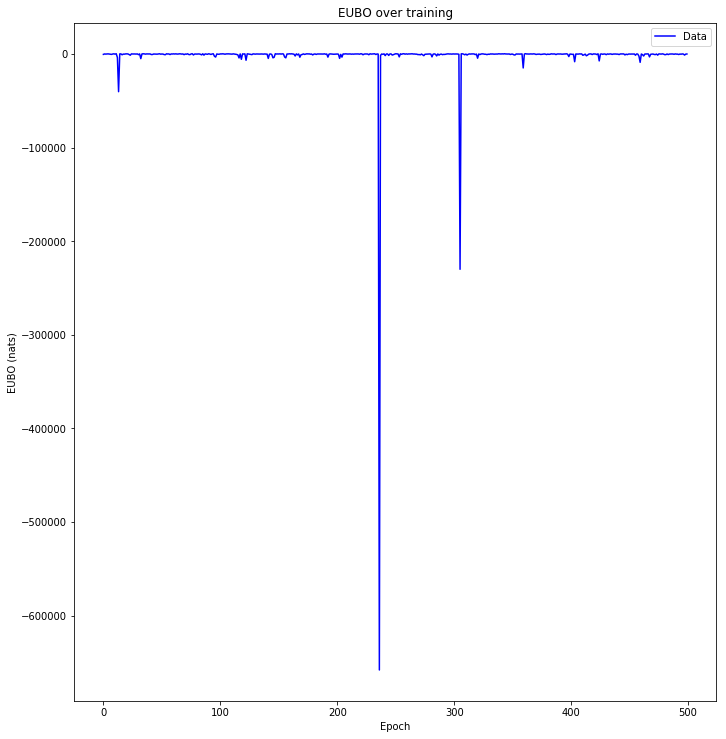

In [20]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    bouncing_ball_smc = generative_model(data, prior_init_params.copy())
    bouncing_ball_proposal = proposal_model(data, variational_init_params.copy())
    importance_sampler = combinators.score_under_proposal(bouncing_ball_smc, bouncing_ball_proposal)
    
    inference, trained_params, eubos = importance.variational_importance(
        importance_sampler, 500, data,
        use_cuda=False, lr=1e-1, inclusive_kl=True,
        patience=200,
    )
    trained_params = utils.vardict({
        k.rsplit('.')[-1]: v for k, v in trained_params.items()
        if 'second' in k
    })
    utils.plot_evidence_bounds(eubos, False)
    
    bouncing_ball_posterior = posterior_model(data, trained_params, bouncing_ball_proposal.folder.operator)
    _, inference, (positions, _, A_pred, final_mu, final_cov) = bouncing_ball_posterior.simulate(data=data)
    As_pred[s] = A_pred.mean(dim=0).detach().numpy()
    final_mus[s] = final_mu.mean(dim=0).detach().numpy()
    final_covs[s] = final_cov.mean(dim=0).detach().numpy()
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory[:, 1:, :].mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce(Foldable(SideEffect(bouncing_ball_step, bouncing_ball_step)))/%d/Foldable(SideEffect(bouncing_ball_step, bouncing_ball_step))(%d,)/bouncing_ball_step/displacement_%d' % (t, t, t+1)].value for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_position_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    modal_directions[s] = bouncing_ball.reflect_directions(trained_params['directions']['loc']['loc'].unsqueeze(0)).squeeze(0)
    
    plt.close('all')

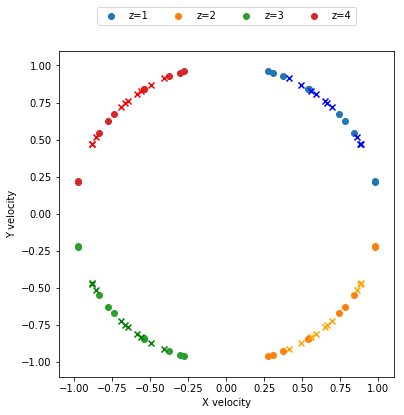

In [21]:
graph_velocity_frequencies(modal_directions.detach())

In [22]:
import bouncing_ball_plots

In [23]:
fs = 3 ## figure size
vmax = 0.3 ## cmap maximum value, to make off-diagonal elements more visible
width_space = 0.05 # space between figures
height_space = 0.05 # space between figures
cov_flag = False # plot the covariances or not
legend_flag = False # plot the legend bar or not
save_flag = True ## save or not

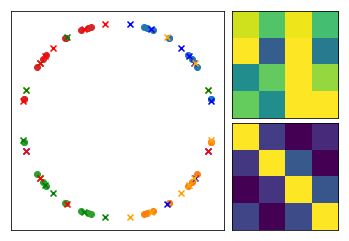

In [24]:
## plot method 1
bouncing_ball_plots.plot_circle_transition(init_v, final_mus, final_covs,
                                           As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

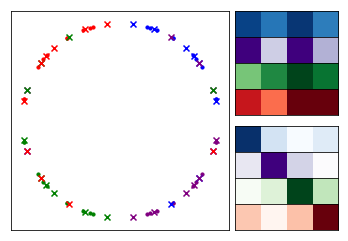

In [25]:
## plot method 2
bouncing_ball_plots.plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

In [26]:
def plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag):

    As_infer = As_pred / As_pred.sum(-1)[:, :, None]
    As_infer = As_infer.mean(0)
    As_true_ave = As_true.mean(0)

    fig = plt.figure(figsize=(fs*1.5 + width_space,fs + height_space))
    gs1 = gridspec.GridSpec(1, 1)
    # , width_ratios=[2,1], height_ratios=[1,1]
    gs1.update(left=0.0, bottom=0.0, right=(2/3), top=1.0, wspace=width_space, hspace=height_space)
    ax1 = fig.add_subplot(gs1[0])

    # ax3 = fig.add_subplot(gs[1, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])

    gs2 = gridspec.GridSpec(4, 1)
    gs2.update(left=2/3 + (1/3)*width_space, bottom=0.5+(1/2)*width_space, right=1.0, top=1.0, wspace=0, hspace=0)
    ax2 = fig.add_subplot(gs2[0, 0])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = fig.add_subplot(gs2[1, 0])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(gs2[2, 0])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax5 = fig.add_subplot(gs2[3, 0])
    ax5.set_xticks([])
    ax5.set_yticks([])

    gs3 = gridspec.GridSpec(4, 1)
    gs3.update(left=2/3 + (1/3)*width_space, bottom=0.0, right=1.0, top=0.5 - (1/2)*width_space, wspace=0, hspace=0)
    ax6 = fig.add_subplot(gs3[0, 0])
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax7 = fig.add_subplot(gs3[1, 0])
    ax7.set_xticks([])
    ax7.set_yticks([])
    ax8 = fig.add_subplot(gs3[2, 0])
    ax8.set_xticks([])
    ax8.set_yticks([])
    ax9 = fig.add_subplot(gs3[3, 0])
    ax9.set_xticks([])
    ax9.set_yticks([])
    markersize = 10.0
    colors = ['b', 'Purple', 'g', 'r']
    ## plot left one
    ax1.scatter(init_v[:,0], init_v[:,1], s=markersize, color=colors[0], label='z=1')
    ax1.scatter(init_v[:,0], -init_v[:,1], s=markersize, color=colors[1], label='z=2')
    ax1.scatter(-init_v[:,0], -init_v[:,1], s=markersize, color=colors[2], label='z=3')
    ax1.scatter(-init_v[:,0], init_v[:,1], s=markersize, color=colors[3], label='z=4')

    for k in range(K):
        ax1.scatter(final_mus[:,k,0], final_mus[:,k,1], c=colors[k], marker='x')
    if cov_flag:
        for k in range(K):
            for s in range(num_series):
                plot_cov_ellipse(cov=final_covs[s, k, :, :], pos=final_mus[s, k, :], nstd=0.3, ax=ax1, alpha=0.3)
    #    ax1.set_xlabel('x velocity')
    #    ax1.set_ylabel('y velocity')
    if legend_flag:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15), ncol=4)

    ax2.imshow(As_infer[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax3.imshow(As_infer[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax4.imshow(As_infer[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax5.imshow(As_infer[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    ax6.imshow(As_true_ave[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax7.imshow(As_true_ave[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax8.imshow(As_true_ave[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax9.imshow(As_true_ave[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    if save_flag:
        fig.savefig('combinator_results.pdf', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.svg', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.png', dpi=600, bbox_inches='tight')

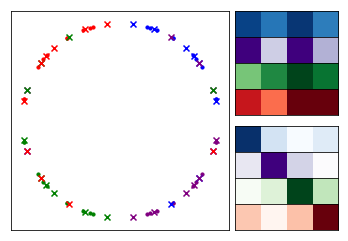

In [27]:
## plot method 2
plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)